In [1]:
!git clone https://github.com/jmnwong/NSL-KDD-Dataset.git

fatal: destination path 'NSL-KDD-Dataset' already exists and is not an empty directory.


In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [3]:
random_state = 12
tf.random.set_seed(random_state)
np.random.seed(random_state)

In [4]:
train = pd.read_csv('NSL-KDD-Dataset/KDDTrain+.txt', header=None)
test = pd.read_csv('NSL-KDD-Dataset/KDDTest+.txt', header=None)

In [5]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

In [6]:
def preprocess(df, is_fit=True):
  # chuyển normal thành 1 và các lớp khác thành 0
  label = np.where(df[41] == 'normal', 'normal', 'abnormal')

  # loại bỏ cột dữ liệu không cần thiết
  df.drop([41, 42], axis=1)

  # chia dữ liệu ra số, chữ để tiện xử lý
  numerical_data = df.select_dtypes(exclude='object').values
  categorical_data = df.select_dtypes(include='object').values

  # chỉ fit với dữ liệu train
  if is_fit:
    encoder.fit(categorical_data)

  # chuyển từ dữ liệu chữ sang onehot
  categorical_data = encoder.transform(categorical_data).toarray()

  # nối dữ liệu số và onehot lại
  data = np.concatenate([numerical_data, categorical_data], axis=1)

  # chỉ fit với dữ liệu train
  if is_fit:
    scaler.fit(data)
  
  # dữ liệu chuẩn hóa về dạng [0, 1]
  data = scaler.transform(data)
  
  return dict(data=data, label=label)

In [7]:
# xử lý dữ liệu
train = preprocess(train, True)
test = preprocess(test, False)

In [8]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      keras.layers.Dense(64, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(8, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(64, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'normal', 'abnormal')

In [9]:
# chia dữ liệu
train_normal = train['data'][train['label'] == 'normal']
train_abnormal = train['data'][train['label'] == 'abnormal']

test_normal = test['data'][test['label'] == 'normal']
test_abnormal = test['data'][test['label'] == 'abnormal']

In [10]:
model = Autoencoder(train_normal.shape[1])
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [11]:
model.fit(train_normal, train_normal, batch_size=64, epochs=100)

Epoch 1/100
1053/1053 [==============================] - 4s 3ms/step - loss: 0.0165
Epoch 2/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0041
Epoch 3/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0032
Epoch 4/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0025
Epoch 5/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0019
Epoch 6/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0015
Epoch 7/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0013
Epoch 8/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 9/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0010
Epoch 10/100
1053/1053 [==============================] - 3s 3ms/step - loss: 9.3097e-04
Epoch 11/100
1053/1053 [==============================] - 3s 3ms/step - loss: 8.6551e-04
Epoch 12/100
1053/1053 [==============================] - 3s 3ms/s

In [12]:
# tính độ lỗi tái tạo cho tất cả các tập dữ liệu

train_normal_re = model.get_reconstruction_error(train_normal)
train_abnormal_re = model.get_reconstruction_error(train_abnormal)

test_normal_re = model.get_reconstruction_error(test_normal)
test_abnormal_re = model.get_reconstruction_error(test_abnormal)

In [24]:
# tìm ngưỡng alpha từ tập train
alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được từ tập train:', threshold)

Ngưỡng vừa tìm được từ tập train: 

0.012032659724354744

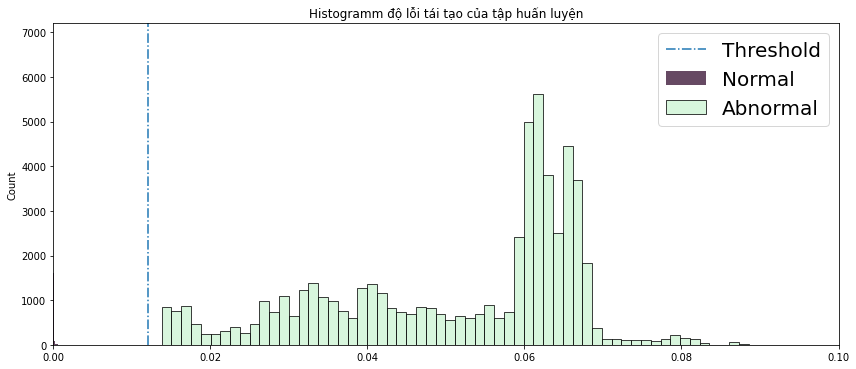

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=train_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.1])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện')
plt.show()

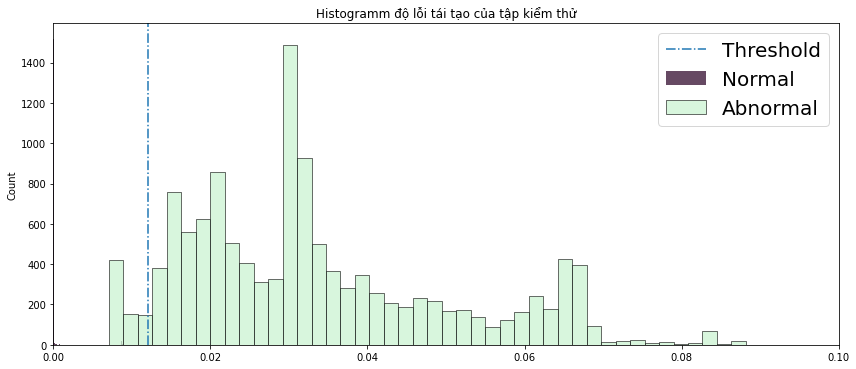

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=test_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.1])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập kiểm thử')
plt.show()

In [17]:
train_label_predict = model.predict_class(train['data'], threshold)
print('Độ chính xác tập huấn luyện', end=': ')
accuracy_score(train['label'], train_label_predict)

Độ chính xác tập huấn luyện: 

0.9984838020845737

In [18]:
test_label_predict = model.predict_class(test['data'], threshold)
print('Độ chính xác tập kiểm thử', end=': ')
accuracy_score(test['label'], test_label_predict)

Độ chính xác tập kiểm thử: 

0.9585699077359829